In [1]:
%cd ../..

/home/work/AnacondaProjects/combinators


In [2]:
import logging

import numpy as np
import probtorch
import torch
from torch.nn.functional import softmax

from combinators.inference import importance, mcmc
from combinators.kernel import kernel, mh
import combinators.model as model
from combinators import utils

In [3]:
import examples.ais.ais_1d_gaussians as ais_example
import examples.ais.image_density as image_density

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
from scipy.misc import imread
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt

img_ary = imread('examples/ais/probtorch-logo-bw.png', mode='L').astype(float)
img_ary = gaussian_filter(img_ary, sigma=1)

/home/work/anaconda3/envs/funcytorch/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


In [6]:
ANNEALING_STEPS = 50
BATCH_SHAPE = (1000,)
NUM_POINTS = 10000

In [7]:
def visualize_ais(log_weights, annealed_points, t=0, filename='probtorch_logo_ais_%d.pdf', show_img=True, transparency=False):
    if show_img:
        plt.matshow(img_ary)
    if transparency:
        plot_log_weights = log_weights - log_weights.max(dim=0)[0]
        rgba_colors = torch.zeros((annealed_points.shape[0], 4))
        rgba_colors[:, 0] = 1.0
        rgba_colors[:, 3] = plot_log_weights.exp()
        if show_img:
            plt.scatter(annealed_points[:, 0], annealed_points[:, 1], c=rgba_colors)
        else:
            fig = plt.figure(None, figsize=plt.figaspect(img_ary))
            ax  = fig.add_axes([0.15, 0.09, 0.775, 0.775])
            ax.set_aspect('equal')
            ax.scatter(annealed_points[:, 0], -annealed_points[:, 1], c=rgba_colors)
    else:
        weights = log_weights.exp()
        plt.scatter(annealed_points[(weights <= .9).nonzero(), 0], annealed_points[(weights <= .9).nonzero(), 1], c='b')
        plt.scatter(annealed_points[(weights > .9).nonzero(), 0], annealed_points[(weights > .9).nonzero(), 1], c='r')
    plt.savefig(filename % t)

In [8]:
K = NUM_POINTS // BATCH_SHAPE[0]
annealed_points = torch.zeros((0, 2))
log_weights = torch.zeros((0))
for _ in range(K):
    proposal = image_density.AnnealingProposal(image_density.ImageProposal(batch_shape=BATCH_SHAPE), ANNEALING_STEPS)
    target = model.Compose(image_density.ProbtorchLogoDensity(batch_shape=BATCH_SHAPE), proposal)
    ais = ais_example.annealed_importance_MH(target, kernel.LinScaledGaussianKernel('ProbtorchLogoDensity.ImageProposal/ImageProposal', 'ImageProposal', scale=100.0, n_steps=ANNEALING_STEPS), moves=ANNEALING_STEPS)
    annealed_batch, trace, log_weight = ais(data={'image': torch.FloatTensor(img_ary)})
    annealed_points = torch.cat((annealed_points, annealed_batch))
    log_weights = torch.cat((log_weights, log_weight))

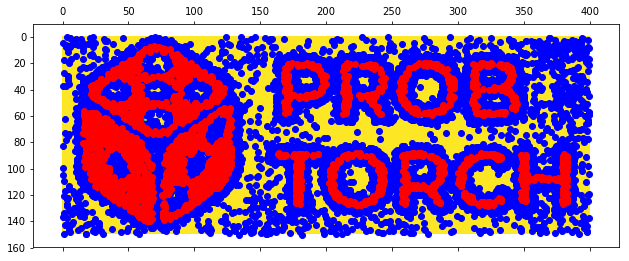

In [9]:
visualize_ais(log_weights, annealed_points, t=ANNEALING_STEPS)

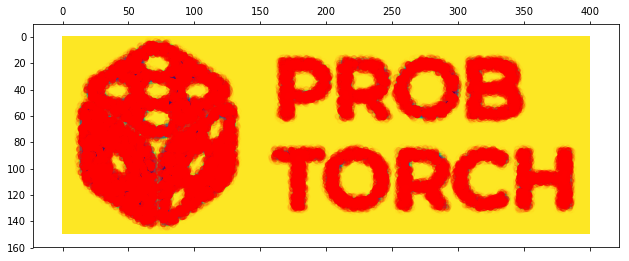

In [10]:
visualize_ais(log_weights, annealed_points, t=ANNEALING_STEPS, transparency=True, filename='probtorch_logo_ais_alphas_%d.pdf')

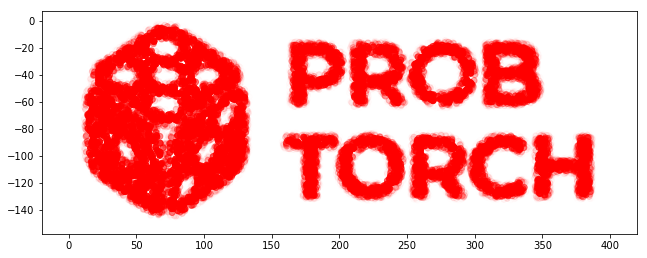

In [11]:
visualize_ais(log_weights, annealed_points, t=ANNEALING_STEPS, transparency=True, show_img=False, filename='probtorch_logo_ais_noimg_%d.pdf')